# Controlling Burgers' Equation with Reinforcement Learning
This notebook will demonstrate how reinforcement learning can be used to control Burgers' equation, a nonlinear PDE. The approach uses the reinforcement learning framework [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) and the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow). As a reinforcement learning algorithm, [PPO](https://arxiv.org/abs/1707.06347v2) was selected.

In [20]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); sys.path.append('../envs'); sys.path.append('../../PDE-Control/PhiFlow')
from phi.flow import *
import matplotlib.pyplot as plt
import burgers_plots as bplt
from experiment import BurgersTraining

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reinforcement Learning Initialization

In [2]:
domain = Domain([32], box=box[0:1]) # 1d grid resolution and physical size
viscosity = 0.003 # viscosity constant for Burgers' equation
step_count = 32 # length of each trajectory
dt = 0.03 # time step size
diffusion_substeps = 1 # how many diffusion steps to perform at each solver step

n_envs = 10 # On how many environments to train in parallel, load balancing
final_reward_factor = step_count # How hard to punish the agent for not reaching the goal if that is the case
steps_per_rollout = step_count * 10 # How many steps to collect per environment between agent updates
training_timesteps = steps_per_rollout * 1000 # How long the actual training should be
n_epochs = 10 # How many epochs to perform during agent update
learning_rate = 1e-4 # Learning rate for agent updates
batch_size = 128 # Batch size for agent updates

To start training, we create a trainer object, which manages the environment and the agent internally. Additionally, a directory for storing models, logs, and hyperparameters is created. This way, training can be continued at any later point using the same configuration. If the model folder specified in `exp_name` already exists, the agent within is loaded. Otherwise, a new agent is created

In [18]:
trainer = BurgersTraining(
    exp_name='ControlBurgersBench2',
    domain=domain,
    viscosity=viscosity,
    step_count=step_count,
    dt=dt,
    diffusion_substeps=diffusion_substeps,
    n_envs=n_envs,
    final_reward_factor=final_reward_factor,
    steps_per_rollout=steps_per_rollout,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

Loading existing agent from rl-models/ControlBurgersBench2/agent.zip
Using new running mean for reward


Now we are set up to start training the agent. The next line will take quite some time to execute, so grab a coffee or take your dog for a walk or so.

`n_rollouts` denotes the length of the training

`save_freq` specifies the number of epochs after which the stored model is overwritten

In [8]:
trainer.train(n_rollouts=1, save_freq=50)

Logging to rl-models/delete/tensorboard-log/PPO_1
Storing agent and hyperparameters to disk...
dict_keys(['num_envs', 'step_count', 'domain', 'dt', 'viscosity', 'diffusion_substeps', 'final_reward_factor', 'exp_name', 'reward_rms'])


/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning:

Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



------------------------------------
| forces             | 1156.845    |
| rew_unnormalized   | 281474.22   |
| rollout/           |             |
|    ep_len_mean     | 32.0        |
|    ep_rew_mean     | -0.23478584 |
| time/              |             |
|    fps             | 756         |
|    iterations      | 1           |
|    time_elapsed    | 4           |
|    total_timesteps | 3200        |
------------------------------------


Let's see how the reward evolved during training

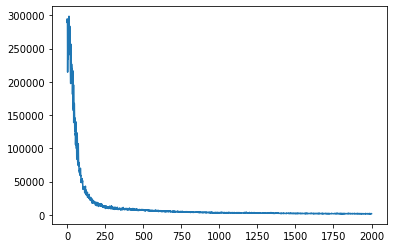

In [19]:
trainer.plot()

Run the cell below to open the tensorboard logs. If necessary, replace the path with the one leading to the log folder of your experiment

In [24]:
%load_ext tensorboard
%tensorboard --logdir rl-models/ControlBurgersBench2/tensorboard-log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Now we can take a look at how the agent is performing:

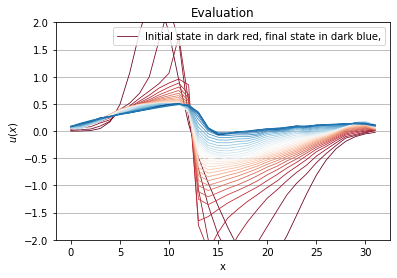

In [11]:
env = trainer.env

obs = env.reset()
bplt.burgers_figure('RL Reconstruction')
plt.plot(obs[0][:,0], color=bplt.gradient_color(0, step_count+1), linewidth=0.8)
plt.legend(['Initial state in dark red, final state in dark blue,'])
plt.ylim(-2, 2)
for frame in range(1, step_count):
    act = trainer.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(act)
    plt.plot(obs[0][:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)
plt.plot(env.goal_state.velocity.data[0,:,0])